In [72]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Punto 1
##  1 – Inverse Filtering   
- a- Blur   
- b- Blur+Noise

Para inverse filtering lo que se intenta hacer es revertir el efecto de la degradación a partir de "dividir" la transformada de Fourier de la transferencia del filtro "degradador", haciendo así que se cancelen y se permita obtener la imagen original. Esto es posible siempre que no haya ruido en la imagen a restaurar, ya que la aplicación del filtro inverso puede amplificar el efecto del ruido y llegar a resultados peores.

Esto último puede verse en la expresión de la transformada de la imagen:
$$\hat{F}(u,v) = \frac{G(u,v)}{H(u,v)} = \frac{F(u,v)+N(u,v)}{H(u,v)} = F(u,v)+\frac{N(u,v)}{H(u,v)}$$
- $\hat{F}(u,v)$: Transformada de Fourier de la estimación de la imagen original.
- $G(u,v)$: Transformada de la Imagen degradada (por el sistema y por el ruido)
- $N(u,v)$: Transformada de la estimación de la función *ruido*.
- $H(u,v)$: Función de transferencia del sistema de degradación.

De lo anterior se ve que si la imagen no está contaminada con ruido, la aplicación del filtro inverso puede dar como resultado la imagen original (siempre y cuando se conozca $H$)


## Inciso a)

In [73]:
def create_kernel(dim):
    # Crea un kernel cuadrado de tamaño dim x dim donde cada celda tiene valor 1/(dim²)
    value = 1.0 / (dim * dim)
    kernel = np.full((dim, dim), value, dtype=np.float32)
    return kernel

def apply_filter(img, kernel):
    imgfft = np.fft.fftshift(np.fft.fft2(img))
    kernelfft = np.fft.fftshift(np.fft.fft2(kernel, s=img.shape))
    filtered = np.fft.ifft2(np.fft.ifftshift(imgfft * kernelfft))
    return np.abs(filtered)

In [74]:
# funciones para filtro inverso
def inverse_filter(degraded_img, kernel, eps=1e-9):
    
    H = np.fft.fft2(kernel, s=degraded_img.shape)
    #transformada de Fourier de la imagen degradada
    G = np.fft.fft2(degraded_img)
    
    #antes de aplicar, shiftear kernel e imagen para centrar
    H = np.fft.fftshift(H)
    G = np.fft.fftshift(G)

    #aplicación del filtro
    F_estimated = (1 / (H+eps)) * G #se le suma eps para que nunca divida por 0
    
    #transformada inversa para la imagen restaurada
    f_estimated = np.fft.ifft2(np.fft.ifftshift(F_estimated))
    f_estimated = np.abs(f_estimated)
    
    return f_estimated.astype(degraded_img.dtype)

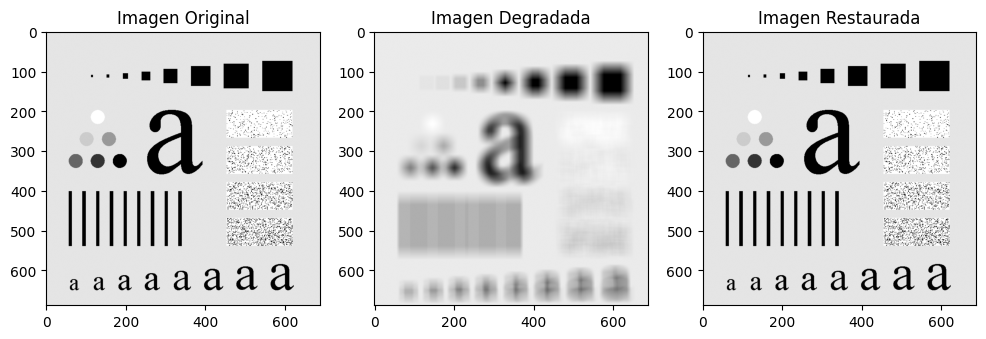

In [75]:
img = cv2.imread('test_pattern.tif', cv2.IMREAD_GRAYSCALE)
kernel_size = 35
kernel = create_kernel(kernel_size)
degraded_img = apply_filter(img, kernel)
restored_img = inverse_filter(degraded_img, kernel)
# Mostrar las imágenes
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('Imagen Original')
plt.imshow(img, cmap='gray')
plt.subplot(1, 3, 2)
plt.title('Imagen Degradada')
plt.imshow(degraded_img, cmap='gray')
plt.subplot(1, 3, 3)
plt.title('Imagen Restaurada')
plt.imshow(restored_img, cmap='gray')
plt.show()

A pesar del blur **extremo** aplicado, se observa que la imagen restaurada es particularmente parecida a la original. Si se observa el MSE, se ve que el error obtenido es completamente aceptable, probablemente producido por el margen que pusimos para que no exista división por 0.

In [76]:
MSE = np.mean((img - restored_img) ** 2)
print(f'Mean Squared Error (MSE) entre la imagen original y la restaurada: {MSE}')

Mean Squared Error (MSE) entre la imagen original y la restaurada: 1.2050135427147298e-05


## Inciso b)

In [77]:
def apply_noise(img, std):
    noise = np.random.normal(0, std, img.shape)
    noisy_img = img + noise
    noisy_img = np.clip(noisy_img, 0, 255)
    return noisy_img.astype(img.dtype)

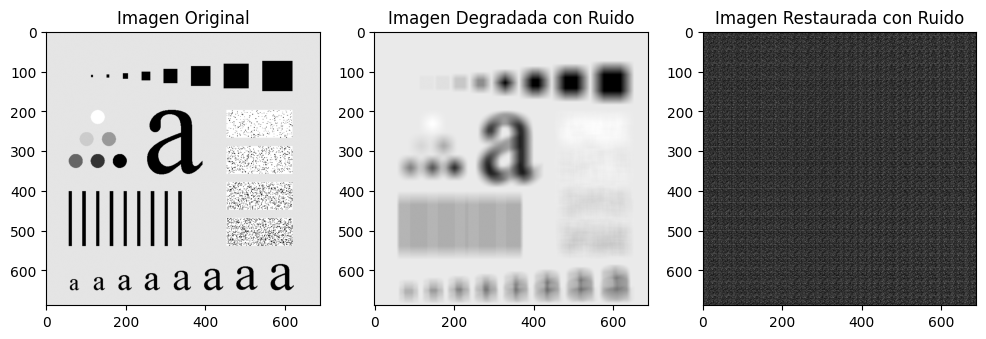

Mean Squared Error (MSE) entre la imagen original y la restaurada: 40853646.27486231


In [78]:
blurred_noisy_img = apply_noise(degraded_img, std=0.1)
restored_noisy_img = inverse_filter(blurred_noisy_img, kernel)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('Imagen Original')
plt.imshow(img, cmap='gray')
plt.subplot(1, 3, 2)
plt.title('Imagen Degradada con Ruido')
plt.imshow(blurred_noisy_img, cmap='gray')
plt.subplot(1, 3, 3)
plt.title('Imagen Restaurada con Ruido')
plt.imshow(restored_noisy_img, cmap='gray')
plt.show()

MSE = np.mean((degraded_img - restored_noisy_img) ** 2)
print(f'Mean Squared Error (MSE) entre la imagen original y la restaurada: {MSE}')

Como se predijo, al haber ruido, el intento de restauración puede llevar a imágenes irreconocibles.

# Punto 2 - Wiener blur + noise

En el Wiener se tiene en cuenta el efecto del ruido en la imagen y se intenta no amplificarlo, resultando en una relación de compromiso entre la calidad de reconstrucción y la amplificación.

Antes propusimos que $\hat{F}=\frac{G}{H}$. La implementación del filtrado basado en Wiener consta de plantear que ahora: $$\hat{F}(u,v) = \frac{H^*(u,v)}{|H(u,v)|^2 + \frac{S_n}{S_f}}\cdot G(u,v)$$

Donde $S_n$ es la potencia de ruido y $S_f$ es la potencia de la imagen "original", y el factor $\frac{S_n}{S_f}$ representa la SNR de la imagen.

Frecuentemente la SNR se aproxima con una constante, ya que por lo general se desconoce a priori.

In [79]:
def apply_wiener_filter(degraded_img, kernel, K):
    H = np.fft.fftshift(np.fft.fft2(kernel, s=degraded_img.shape))
    G = np.fft.fftshift(np.fft.fft2(degraded_img))

    F_estimated = (np.conj(H) / (np.abs(H)**2 + K)) * G
    
    f_estimated = np.fft.ifft2(np.fft.ifftshift(F_estimated))
    f_estimated = np.abs(f_estimated)
    
    return f_estimated.astype(degraded_img.dtype)

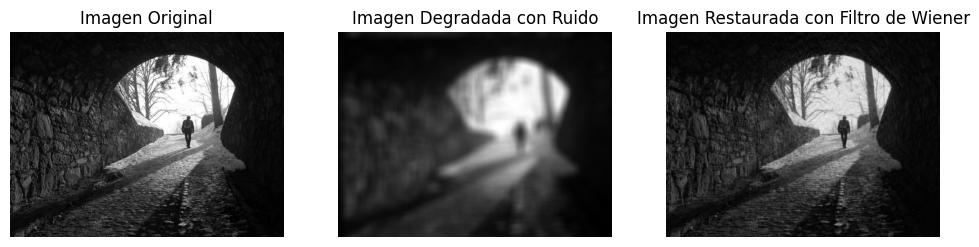

In [80]:
img = cv2.imread('tun.jpg', cv2.IMREAD_GRAYSCALE)
kernel_size = 35
kernel = create_kernel(kernel_size)
noise_std = 0.1
degraded_img = apply_filter(img, kernel)
blurred_noisy_img = apply_noise(degraded_img, noise_std)
restored_wiener_img = apply_wiener_filter(blurred_noisy_img, kernel, K=2e-5)    #K ajustado observando resultados (se observa que
                                                                                #con K tendiendo a 0, se obtiene el caso anterior)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('Imagen Original')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title('Imagen Degradada con Ruido')
plt.imshow(blurred_noisy_img, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title('Imagen Restaurada con Filtro de Wiener')
plt.imshow(restored_wiener_img, cmap='gray')
plt.axis('off')
plt.show()


In [81]:
MSE = np.mean((img - restored_wiener_img) ** 2)
print(f'Mean Squared Error (MSE) entre la imagen original y la restaurada: {MSE}')

# comparando con k --> 0
restored_wiener_img_k0 = apply_wiener_filter(blurred_noisy_img, kernel, K=1e-10)    #K muy pequeño para simular k-->0
MSE_k0 = np.mean((img - restored_wiener_img_k0) ** 2)
print(f'Mean Squared Error (MSE) entre la imagen original y la restaurada con K-->0: {MSE_k0}')

Mean Squared Error (MSE) entre la imagen original y la restaurada: 148.60841826825794
Mean Squared Error (MSE) entre la imagen original y la restaurada con K-->0: 771789.1295059718


# Punto 3 - Blind deconvolution

Este método se usa cuando no se tiene conocimiento del filtro que causó la degradación. En este caso se estima la imagen original y la DFT a partir de la imagen degradada en un proceso iterativo.

In [82]:
import numpy as np

def psf2otf(psf, out_shape):
    pad = np.zeros(out_shape, dtype=np.float32)
    ph, pw = psf.shape
    pad[:ph, :pw] = psf
    pad = np.fft.ifftshift(pad)   # mover centro del PSF a (0,0) antes de FFT
    return np.fft.fft2(pad)

def blind_rl_freq(y, psf_size=15, n_outer=10, n_x=20, n_h=5, eps=1e-7):
    """
    Blind Richardson–Lucy en dominio de la frecuencia.
    """
    # asegurar float en 0..1
    y = y.astype(np.float32, copy=False)
    if y.max() > 1.0:
        y = y / 255.0
    y = np.clip(y, 0.0, None)

    Himg, Wimg = y.shape
    if isinstance(psf_size, int):
        ph = pw = int(psf_size)
    else:
        ph, pw = map(int, psf_size)

    # inicializaciones
    x = y.copy() + 1e-6
    h = np.ones((ph, pw), dtype=np.float32)
    h /= h.sum()

    for _ in range(n_outer):
        H_otf = psf2otf(h, (Himg, Wimg))
        H_conj = np.conj(H_otf)

        # update x (RL) usando FFT
        for _ in range(n_x):
            X = np.fft.fft2(x)
            est = np.fft.ifft2(H_otf * X).real
            est = np.fft.fftshift(est)
            est = np.maximum(est, eps)
            ratio = y / est
            Rf = np.fft.fft2(ratio)
            corr = np.fft.ifft2(H_conj * Rf).real
            corr = np.fft.fftshift(corr) 
            x *= corr
            x = np.clip(x, 0.0, None)

        # update h (RL) usando FFT
        X_otf = np.fft.fft2(x)
        X_conj = np.conj(X_otf)
        for _ in range(n_h):
            est = np.fft.ifft2(H_otf * X_otf).real
            est = np.fft.fftshift(est)            
            est = np.maximum(est, eps)
            ratio = y / est
            Rf = np.fft.fft2(ratio)
            num_full = np.fft.ifft2(X_conj * Rf).real  # numerador del tamaño de laimagen

            num_full_shifted = np.fft.fftshift(num_full)
            Hf, Wf = num_full_shifted.shape
            y0 = (Hf - ph) // 2
            x0 = (Wf - pw) // 2
            num = num_full_shifted[y0:y0+ph, x0:x0+pw]

            # actualización para h, no negativa y normalización
            h *= (np.clip(num, 0.0, None) + eps)
            h = np.clip(h, 0.0, None)
            s = h.sum()
            if s > 0:
                h /= s

            # refrescar OTF para la siguiente iteración interna
            H_otf = psf2otf(h, (Himg, Wimg))
            H_conj = np.conj(H_otf)

    return np.clip(x, 0.0, 1.0).astype(np.float32), h.astype(np.float32)


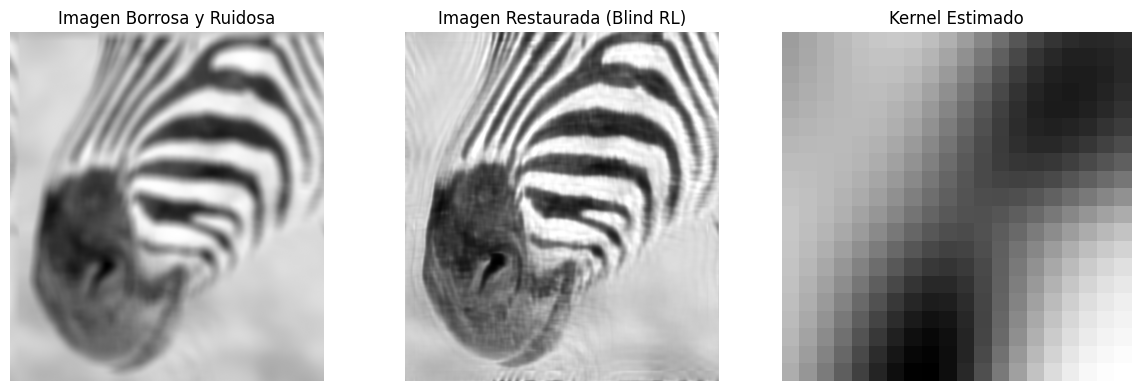

Mean Squared Error (MSE): 108.12882995605469


In [83]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('zebra.png', cv2.IMREAD_GRAYSCALE)
degraded_img = apply_filter(img, create_kernel(20))
blurred_noisy_img = apply_noise(degraded_img, std=0.1)

restored_blind_img, estimated_kernel = blind_rl_freq(blurred_noisy_img, psf_size=20, n_outer=10, n_x=15, n_h=5)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(blurred_noisy_img, cmap='gray')
plt.title('Imagen Borrosa y Ruidosa')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(restored_blind_img, cmap='gray')
plt.title('Imagen Restaurada (Blind RL)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(estimated_kernel, cmap='gray')
plt.title('Kernel Estimado')
plt.axis('off')
plt.tight_layout()
plt.show()

y = img.astype(np.float32, copy=False)
if y.max() > 1.0:
    y = y / 255.0
y = np.clip(y, 0.0, None)

MSE = np.mean((img - restored_blind_img*255) ** 2)
print(f'Mean Squared Error (MSE): {MSE}')

# Punto 4 - Motion Blur

El motion blur puede verse como una PSF (Point Spread Function) que consta de una línea. Al convolucionar esta PSF con la imagen original, debería obtenerse un motion blur de una distancia proporcional a la longitud de la línea.

In [84]:
# El motion blur es una PSF que puede modelarse como una línea en una dirección específica.
# esto es porque el movimiento de la cámara o del objeto durante la exposición crea un efecto de desenfoque lineal.

import numpy as np
import cv2

def motion_psf(length, angle, psf_size):
    #la idea es que no esté centrado en (0,0)
    h = np.zeros((psf_size, psf_size), dtype=np.float32)
    
    # centro del kernel
    center = psf_size // 2

    # coordenadas extremo a extremo de la línea
    x0 = center
    y0 = center
    x1 = center + length/2 * np.cos(np.deg2rad(angle))
    y1 = center + length/2 * np.sin(np.deg2rad(angle))
    
    # dibujar la línea en la PSF
    cv2.line(h, (int(x0), int(y0)), (int(x1), int(y1)), 1.0, 1)
    
    # normalizar
    h /= h.sum() + 1e-9
    return h

def psf2otf(psf, out_shape):
    pad = np.zeros(out_shape, np.float32)
    ph, pw = psf.shape
    pad[:ph, :pw] = psf
    return np.fft.fft2(pad)

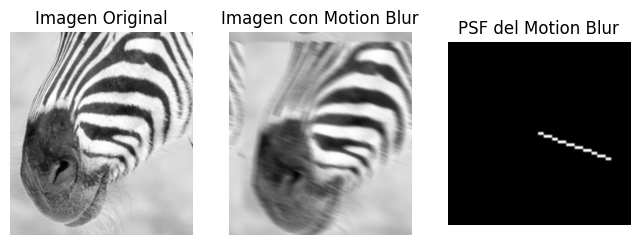

In [85]:
img = cv2.imread('zebra.png', cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
psf = motion_psf(length=55, angle=20, psf_size=65)

H = psf2otf(psf, img.shape)
F = np.fft.fft2(img)

G = H * F
blurred = np.fft.ifft2(G).real
blurred = np.clip(blurred, 0.0, 1.0)

plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.title('Imagen Original')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title('Imagen con Motion Blur')
plt.imshow(blurred, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title('PSF del Motion Blur')
plt.imshow(psf, cmap='gray')
plt.axis('off')
plt.show()

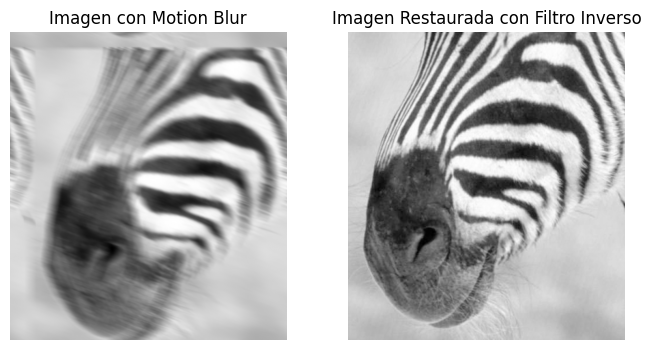

Mean Squared Error (MSE): 1.0511632353882305e-05


In [86]:
#puede aplicarse el filtro inverso de wiener porque se conoce el kernel
restored_img = apply_wiener_filter(blurred, psf, K=1e-6) #k pequeño porque no hay ruido
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Imagen con Motion Blur')
plt.imshow(blurred, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Imagen Restaurada con Filtro Inverso')
plt.imshow(restored_img, cmap='gray')
plt.axis('off')
plt.show()
MSE = np.mean((img - restored_img) ** 2)
print(f'Mean Squared Error (MSE): {MSE}')

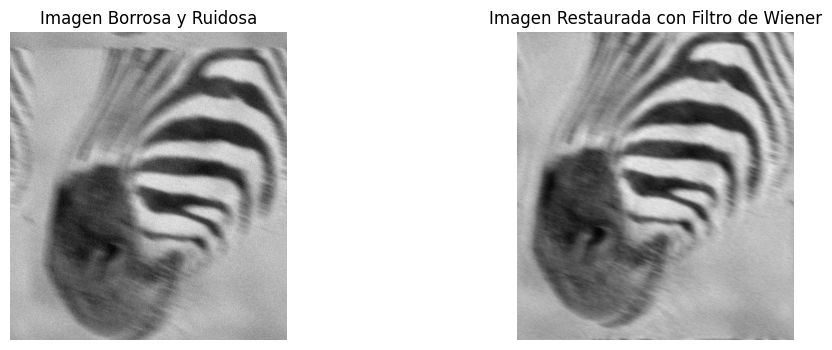

Mean Squared Error (MSE): 0.015127754770219326


In [87]:
# Y si aplicamos ruido también
blurred_noisy = apply_noise(blurred, std=0.05)
restored_noisy = apply_wiener_filter(blurred_noisy, psf, K=15e-2) #k mayor por el ruido
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('Imagen Borrosa y Ruidosa')
plt.imshow(blurred_noisy, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Imagen Restaurada con Filtro de Wiener')
plt.imshow(restored_noisy, cmap='gray')
plt.axis('off')
plt.show()
MSE = np.mean((img - restored_noisy) ** 2)
print(f'Mean Squared Error (MSE): {MSE}')

# Punto 5 - Regularización y métodos iterativos

Ya usamos un método iterativo en el punto 3 con Blind Deconvolution, ahí usamos un algoritmo basado en Richardson-Lucy. A ese algoritmo puede agregarse una sección de regularización, en la que puede prevenirse que el resultado tenga artefactos como se ve en la imagen del punto 3.

### Richardson–Lucy Regularizado (RL + L2 / RL + TV)

El método de **Richardson–Lucy (RL)** es un algoritmo iterativo para deconvolución bajo un modelo de ruido Poisson.  
La actualización básica es multiplicativa:

$$
x_{k+1} = x_k \cdot 
\mathcal{F}^{-1}\{ \overline{H} \cdot 
\mathcal{F}( y / (H * x_k) ) \}.
$$

Para evitar amplificación de ruido, añadimos regularización.

---

### Regularización L2

Penaliza la diferencia entre la imagen actual y una versión suavizada:

$$
x \leftarrow x - \lambda (x - G_\sigma * x)
$$

donde $G_\sigma$ es un filtro gaussiano, y $\lambda$ es el peso de la regularización.
Reduce ruido pero suaviza bordes.

---

### Regularización TV (Total Variation)

TV penaliza variaciones locales fuertes, preservando bordes.

Gradiente:

$$
\nabla x = (x_x, x_y)
$$

Normalización:

$$
p = \frac{\nabla x}{\|\nabla x\| + \varepsilon}
$$

Actualización usando la divergencia:

$$
x \leftarrow x - \lambda \, \nabla \cdot p
$$

La función `divergence(px, py)` calcula:

$$
\nabla \cdot p = 
\frac{\partial p_x}{\partial x} +
\frac{\partial p_y}{\partial y}
$$

mediante diferencias finitas.

---

Con estas regularizaciones, RL se vuelve más estable y menos ruidoso, permitiendo más iteraciones sin que explote el ruido.


In [88]:
def divergence(px, py):
    """Compute divergence of vector field (px, py) using finite differences."""
    div = np.zeros_like(px)
    div[:, :-1] += px[:, :-1] - px[:, 1:]
    div[:-1, :] += py[:-1, :] - py[1:, :]
    return div

def richardson_lucy_reg(degraded_img, kernel, num_iterations, reg_param=0.01, reg_type='L2', eps=1e-9):

    H_otf = psf2otf(kernel, degraded_img.shape)
    H_conj = np.conj(H_otf)

    # inicialización
    x = np.full(degraded_img.shape, 0.5, dtype=np.float32)

    for _ in range(num_iterations):

        X = np.fft.fft2(x)

        # estimación
        est = np.fft.ifft2(H_otf * X).real
        est = np.maximum(est, eps)

        # ratio
        ratio = degraded_img / est

        # corrección RL
        Rf = np.fft.fft2(ratio)
        corr = np.fft.ifft2(H_conj * Rf).real

        # update multiplicativo
        x *= corr

        # --- REGULARIZACIÓN ---
        if reg_type == 'L2':
            smooth = cv2.GaussianBlur(x, (5, 5), 0)
            x -= reg_param * (x - smooth)

        elif reg_type == 'TV':
            # gradiente
            grad_x = cv2.Sobel(x, cv2.CV_32F, 1, 0, ksize=3) #calcula la "derivada" de la imagen
            grad_y = cv2.Sobel(x, cv2.CV_32F, 0, 1, ksize=3)

            magnitude = np.sqrt(grad_x**2 + grad_y**2) + eps
            px = grad_x / magnitude
            py = grad_y / magnitude

            div = divergence(px, py)
            x -= reg_param * div

        # no negatividad
        x = np.clip(x, 0.0, None)

    return x.astype(np.float32)


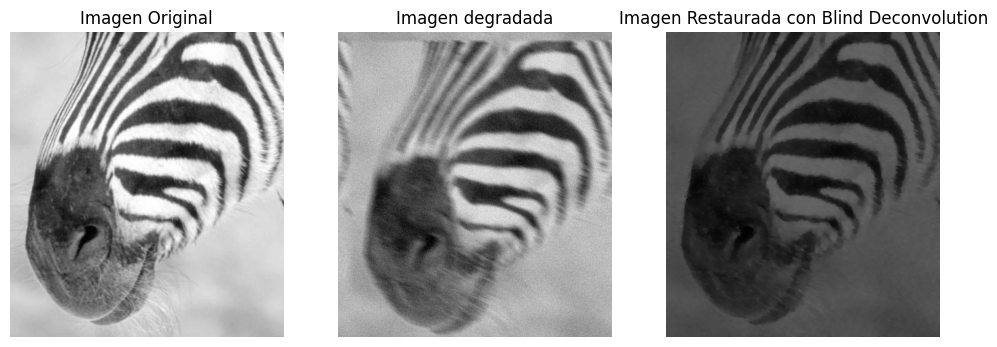

In [89]:
kernel_size = 35
img = cv2.imread('zebra.png', cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
psf = motion_psf(length=55, angle=20, psf_size=kernel_size)
blurred = apply_filter(img, psf)
blurred_noisy_img = apply_noise(blurred, std=0.05)
restored_RL = richardson_lucy_reg(blurred_noisy_img, psf, num_iterations=200, reg_param=0.01, reg_type='TV')
restored_RL = (restored_RL - restored_RL.min()) / (restored_RL.max() - restored_RL.min())
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('Imagen Original')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title('Imagen degradada')
plt.imshow(blurred_noisy_img, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title('Imagen Restaurada con Blind Deconvolution')
plt.imshow(restored_RL, cmap='gray')
plt.axis('off')
plt.show()


In [90]:
MSE = np.mean((img - restored_RL) ** 2)
print(f'Mean Squared Error (MSE) entre la imagen original y la restaurada: {MSE}')
print(f'max value restored: {restored_RL.max()}')
print(f'min value restored: {restored_RL.min()}')
print(f'max value original: {img.max()}')
print(f'min value original: {img.min()}')

Mean Squared Error (MSE) entre la imagen original y la restaurada: 0.1871185451745987
max value restored: 1.0
min value restored: 0.0
max value original: 0.9960784316062927
min value original: 0.0


Se observa que aunque la imagen restaurada está más oscura, se logró restaurar con una calidad razonable, sin que el ruido sea predominante.

# Compensar interferencia

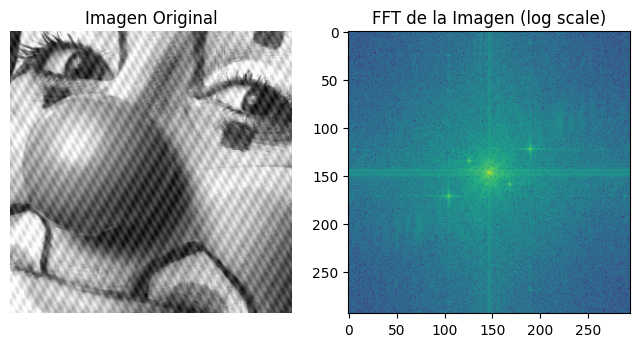

In [91]:
img = cv2.imread('clown.jpg', cv2.IMREAD_GRAYSCALE)
img_fft = np.fft.fft2(img)
img_fft_show = np.log(np.abs(np.fft.fftshift(img_fft)))

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Imagen Original')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('FFT de la Imagen (log scale)')
plt.imshow(img_fft_show)
plt.show()

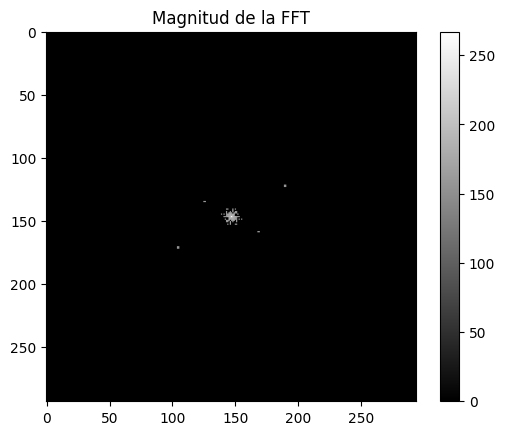

Coordenadas de las deltas detectadas en la FFT:
[122 189]
[122 190]
[123 189]
[123 190]
[135 125]
[135 126]
[141 143]
[141 144]
[141 148]
[141 150]
[142 148]
[143 143]
[143 146]
[143 148]
[143 150]
[143 151]
[144 143]
[144 145]
[144 146]
[144 147]
[144 149]
[144 150]
[144 151]
[145 139]
[145 141]
[145 143]
[145 144]
[145 145]
[145 146]
[145 147]
[145 148]
[145 149]
[145 152]
[146 143]
[146 144]
[146 145]
[146 146]
[146 147]
[146 148]
[146 149]
[147 141]
[147 142]
[147 143]
[147 144]
[147 145]
[147 146]
[147 147]
[147 148]
[147 149]
[147 150]
[147 151]
[147 152]
[147 153]
[148 145]
[148 146]
[148 147]
[148 148]
[148 149]
[148 150]
[148 151]
[149 142]
[149 145]
[149 146]
[149 147]
[149 148]
[149 149]
[149 150]
[149 151]
[149 153]
[149 155]
[150 143]
[150 144]
[150 145]
[150 147]
[150 148]
[150 149]
[150 151]
[151 143]
[151 144]
[151 146]
[151 148]
[151 151]
[152 146]
[153 144]
[153 146]
[153 150]
[153 151]
[159 168]
[159 169]
[171 104]
[171 105]
[172 104]
[172 105]


In [92]:
#se ve en la FFt que la imagen tiene deltas en algunas frecuencias. Si encuentro esas frecuencias, puedo "eliminarlas" para suavizar la imagen.

#Busco dónde están las deltas y a qué frecuencias corresponden.
#puedo usar el método de threshold, calculo el cuadrado para que las deltas resalten más
img_fft_magnitude = np.log(np.abs(np.fft.fftshift(np.fft.fft2(img))) + 1)**2
threshold = 150  # valor de umbral para detectar deltas
#aplico threshold
img_fft_magnitude[img_fft_magnitude < threshold] = 0
#mostrar la FFT con el threshold aplicado
plt.imshow(img_fft_magnitude, cmap='gray')
plt.colorbar()
plt.title('Magnitud de la FFT')
plt.show()
delta_coords = np.argwhere(img_fft_magnitude > threshold)
print("Coordenadas de las deltas detectadas en la FFT:")
for coord in delta_coords:
    print(coord)

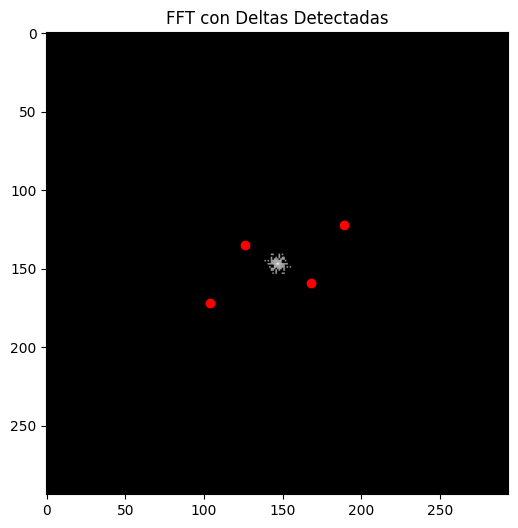

In [93]:
#busqué a ojo las coordenadas de las deltas, las ploteo para comprobar
plt.figure(figsize=(6, 6))
plt.imshow(img_fft_magnitude, cmap='gray')
plt.title('FFT con Deltas Detectadas')

#coordenadas encontradas
delta_positions = [(122, 189), (135, 126), (159, 168), (172, 104)]
for y, x in delta_positions:
    plt.plot(x, y, 'ro')  # marcar las deltas con puntos rojos
plt.show()

In [94]:
#busco las frecuencias correspondientes a esas posiciones, que son las distancias al centro de la FFT
H, W = img.shape
delta_frequencies = []
for y, x in delta_positions:
    freq_y = abs(y - H//2)
    freq_x = abs(x - W//2)
    delta_frequencies.append(np.sqrt(freq_x**2 + freq_y**2))
    print(f"Delta en posición ({y}, {x}) corresponde a frecuencia: {delta_frequencies[-1]:.2f}")

Delta en posición (122, 189) corresponde a frecuencia: 48.88
Delta en posición (135, 126) corresponde a frecuencia: 24.19
Delta en posición (159, 168) corresponde a frecuencia: 24.19
Delta en posición (172, 104) corresponde a frecuencia: 49.74


Esto dice que las interferencias están en aproximadamente 50Hz y 25Hz.

In [95]:
# funcion que elimina las deltas en las posiciones dadas (filtro notch [demasiado] simple)
def notch_filter(img_fft, delta_positions, notch_size=5):
    H, W = img_fft.shape
    filtered_fft = img_fft.copy()
    
    for y, x in delta_positions:
        y_start = max(y - notch_size // 2, 0)
        y_end = min(y + notch_size // 2 + 1, H)
        x_start = max(x - notch_size // 2, 0)
        x_end = min(x + notch_size // 2 + 1, W)
        
        # eliminar la delta (poner a cero)
        filtered_fft[y_start:y_end, x_start:x_end] = 0
    
    return filtered_fft

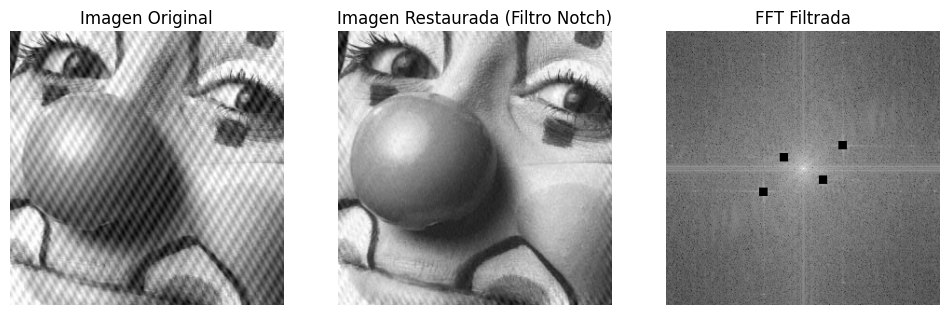

In [96]:
#restauración de la imagen aplicando el filtro notch
img_fft = np.fft.fft2(img)
filtered_fft = notch_filter(np.fft.fftshift(img_fft), delta_positions, notch_size=9)
#transformada inversa para obtener la imagen restaurada
restored_img = np.fft.ifft2(np.fft.ifftshift(filtered_fft)).real
restored_img = np.clip(restored_img, 0.0, 255.0).astype(np.uint8)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('Imagen Original')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title('Imagen Restaurada (Filtro Notch)')
plt.imshow(restored_img, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title('FFT Filtrada')
plt.imshow(np.log(np.abs(filtered_fft) + 1), cmap='gray')
plt.axis('off')
plt.show()

## Qué pasa si intento sacar la interferencia con un método iterativo?

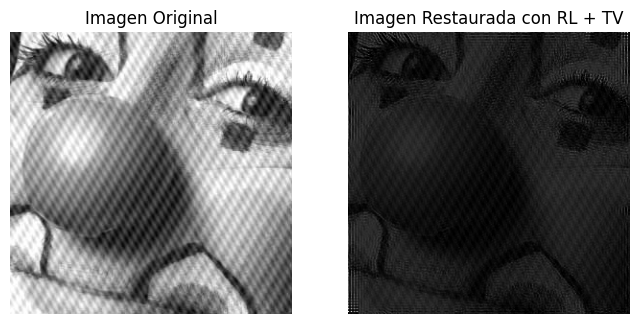

In [ ]:
restored_img = richardson_lucy_reg(img, np.ones((3,3)), num_iterations=200, reg_param=0.001, reg_type='TV')
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Imagen Original')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Imagen Restaurada con RL + TV')
plt.imshow(restored_img, cmap='gray')
plt.axis('off')
plt.show()

In [107]:
MSE = np.mean((img - restored_img) ** 2)
print(f'Mean Squared Error (MSE): {MSE}')

Mean Squared Error (MSE): 11717.0908203125


Puede verse que en este caso el método falla, pues el ruido no es una distribución aleatoria